# Testing Facebook Prophet
For time series predictions on Crypto

In [298]:
# Libraries
from tqdm import tqdm
import pandas as pd
from prophet import Prophet
import yfinance as yf
from datetime import datetime, timedelta
import plotly.express as px
import numpy as np

# 1.  Acquiring and Preprocessing Data

## Getting Prices 
From 2 years ago til now

In [50]:
# Time periods
now = datetime.now()

# How far back to retrieve tweets
ago = now - timedelta(days=730)

# Designating the Ticker
crypto = yf.Ticker("BTC-USD")

# Getting price history
df = crypto.history(start=ago.strftime("%Y-%m-%d"), end=now.strftime("%Y-%m-%d"), interval="1d")

## Some Data Preprocessing

In [51]:
# Getting the N Day Moving Average and rounding the values
df['MA'] = df[['Open']].rolling(window=5).mean().apply(lambda x: round(x, 2))

# Dropping the NaNs
df.dropna(inplace=True)

## Formatting DF for FB Prophet

In [52]:
# Formatted
df = df.reset_index().rename(columns={"Date": "ds", "MA": "y"})
df

,ds,Open,High,Low,Close,Volume,Dividends,Stock Splits,y
0,2019-09-22,10024.115234,10074.444336,9922.533203,10070.392578,13199651698,0,0,10184.47
1,2019-09-23,10067.962891,10074.238281,9727.143555,9729.324219,15144925408,0,0,10148.51
2,2019-09-24,9729.321289,9804.317383,8370.801758,8620.566406,25002886689,0,0,10054.27
3,2019-09-25,8603.428711,8744.828125,8325.396484,8486.993164,21744728353,0,0,9721.70
4,2019-09-26,8487.669922,8515.685547,7895.629395,8118.967773,19258205289,0,0,9382.50
...,...,...,...,...,...,...,...,...,...
717,2021-09-12,45206.628906,46364.878906,44790.460938,46063.269531,27881980161,0,0,45815.13
718,2021-09-13,46057.214844,46598.679688,43591.320312,44963.074219,40969943253,0,0,45661.02
719,2021-09-14,44960.050781,47218.125000,44752.332031,47092.492188,38652152880,0,0,45498.08
720,2021-09-15,47098.000000,48450.468750,46773.328125,48176.347656,30484496466,0,0,45638.35


# 2. Training and Predicting with the Model

## Fitting to FB Prophet

In [53]:
# Setting up Prophet
m = Prophet(
    daily_seasonality=True, 
    yearly_seasonality=True, 
    weekly_seasonality=True
)

# Fitting to the prices
m.fit(df[['ds', 'y']])

## Getting Future Dates for Forecast

In [54]:
# Future DF of 3 months
future = m.make_future_dataframe(periods=90)

## Forecasting Crypto Prices

In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2019-09-22,10716.354698,8479.655793,13090.494692
1,2019-09-23,10552.943475,8090.584980,12855.338110
2,2019-09-24,10380.653111,7861.333284,12717.385988
3,2019-09-25,10207.003986,7793.687485,12487.069982
4,2019-09-26,10033.048070,7667.576989,12431.611037
...,...,...,...,...
807,2021-12-11,72268.927993,63572.920230,80236.539395
808,2021-12-12,72467.745483,63922.410235,81120.261744
809,2021-12-13,72689.336478,64173.410596,81547.612735
810,2021-12-14,72914.120820,64583.330799,81849.249209


# 3. Visualizing Forecast

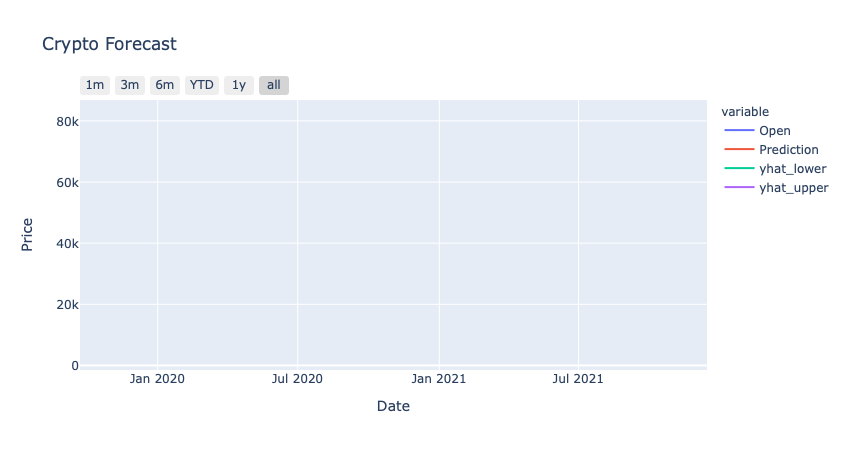

In [56]:
# Visual DF
vis_df = df[['ds','Open']].append(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
).rename(columns={'yhat': 'Prediction'})

# Visualizing results
fig = px.line(
    vis_df,
    x='ds',
    y=['Open', 'Prediction', 'yhat_lower', 'yhat_upper'],
    title='Crypto Forecast',
    labels={'value':'Price',
            'ds': 'Date'}
)

# Adding a slider
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

# 4. Consolidated Previous Steps into Functions

In [37]:
def getData(ticker, window, ma_period):
    """
    Grabs price data from a given ticker. Retrieves prices based on the given time window; from now
    to N days ago.  Sets the moving average period for prediction. Returns a preprocessed DF
    formatted for FB Prophet.
    """
    # Time periods
    now = datetime.now()

    # How far back to retrieve tweets
    ago = now - timedelta(days=window)

    # Designating the Ticker
    crypto = yf.Ticker(ticker)

    # Getting price history
    df = crypto.history(start=ago.strftime("%Y-%m-%d"), end=now.strftime("%Y-%m-%d"), interval="1d")
    
    # Getting the N Day Moving Average and rounding the values
    df['MA'] = df[['Open']].rolling(window=ma_period).mean().apply(lambda x: round(x, 2))

    # Dropping the NaNs
    df.dropna(inplace=True)

    # Formatted for FB Prophet
    df = df.reset_index().rename(columns={"Date": "ds", "MA": "y"})
    
    return df

In [38]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(periods=forecast_period)
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [47]:
def visFBP(df, forecast):
    """
    Given two dataframes: before training df and a forecast df, returns
    a visual chart of the predicted values and actual values.
    """
    # Visual DF
    vis_df = df[['ds','Open']].append(forecast).rename(
        columns={'yhat': 'Prediction',
                 'yhat_upper': "Predicted High",
                 'yhat_lower': "Predicted Low"}
    )

    # Visualizing results
    fig = px.line(
        vis_df,
        x='ds',
        y=['Open', 'Prediction', 'Predicted High', 'Predicted Low'],
        title='Crypto Forecast',
        labels={'value':'Price',
                'ds': 'Date'}
    )

    # Adding a slider
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return fig.show()

## Running the Functions

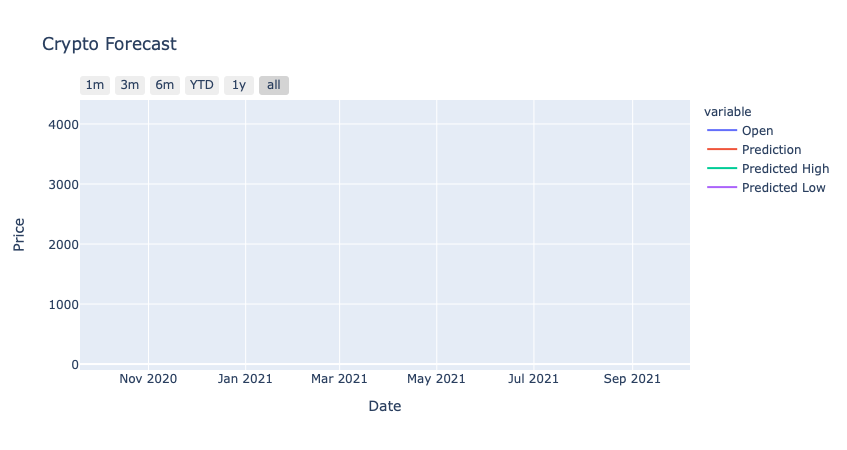

In [257]:
# Getting and Formatting Data
df = getData("ETH-USD", window=365, ma_period=3)

# Training and Predicting Data
forecast = fbpTrainPredict(df, forecast_period=21)

# Visualizing Data
visFBP(df, forecast)

# 5. Backtesting 
Using vectorization

In [330]:
def runningFBP(ticker, window=730, ma_period=5, days_to_train=365, forecast_period=10):
    """
    Runs the facebook prophet model over the provided ticker.  Trains with last N days given 
    by days_to_train.  Forecast N days into the future based on given forecast_period.  Moving average 
    is applied to the dataset based on given ma_period. Returns the root mean squared error and a DF 
    of the actual values and the predicted values for the same day.
    """

    # Getting and Formatting Data
    df = getData(ticker, window=window, ma_period=ma_period)
    
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model on each day
    for i in tqdm(range(days_to_train, window-forecast_period, forecast_period)):

        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(df[i-days_to_train:i], 
                                   forecast_period=forecast_period).tail(forecast_period)[['ds',
                                                                                           'yhat',
                                                                                           'yhat_lower',
                                                                                           'yhat_upper']]

        # Adding the last day predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Combining the predicted df and original df
    comb_df = df[['ds', 'Open']].merge(pred_df, 
                                       on='ds', 
                                       how='outer').sort_values(by='ds')
    
    # Dropping most NaNs and resetting index
    comb_df = comb_df.fillna(method='ffill').dropna().reset_index(drop=True).set_index('ds')

    return comb_df

In [331]:
bt_df = runningFBP("ETH-USD", 
                   window=730, 
                   ma_period=5, 
                   days_to_train=370, 
                   forecast_period=10)

100%|██████████| 35/35 [00:24<00:00,  1.41it/s]


In [332]:
bt_df

,Open,yhat,yhat_lower,yhat_upper
ds,,,,
2020-09-27,354.587219,356.984828,343.301799,369.609334
2020-09-28,357.311157,355.520077,342.210459,368.736127
2020-09-29,354.974823,354.110006,339.012684,367.292862
2020-09-30,359.942352,352.626803,339.223970,366.778763
2020-10-01,360.004639,350.936144,337.088583,365.095467
...,...,...,...,...
2021-09-12,3270.291748,3281.679546,3090.854523,3463.059879
2021-09-13,3407.471924,3277.855151,3085.522982,3457.678701
2021-09-14,3286.316406,3276.932094,3091.513064,3460.815331


In [345]:
def get_prophet_positions(df, short=False):
    """
    For these positions, buy when actual value is below the lower bound and short 
    when actual value is above upper bound. Otherwise do nothing.
    """
    if df['Open'] >= df['yhat_upper']:
        return 1
    elif df['Open'] <= df['yhat_lower'] and short:
        return -1
    else:
        return 0

In [346]:
bt_df['positions'] = bt_df.apply(get_prophet_positions, axis=1)

# Compensating for lookahead bias
bt_df['positions'] = bt_df['positions'].shift(1)

In [347]:
# Getting log returns
bt_df['log_returns'] = bt_df['Open'].apply(np.log).diff()

bt_df.dropna(inplace=True)

In [348]:
bt_df

,Open,yhat,yhat_lower,yhat_upper,positions,log_returns
ds,,,,,,
2020-09-30,359.942352,352.626803,339.223970,366.778763,0.0,0.013897
2020-10-01,360.004639,350.936144,337.088583,365.095467,0.0,0.000173
2020-10-02,353.220184,349.238446,335.508528,362.826325,0.0,-0.019025
2020-10-03,346.502655,347.556202,334.594024,361.722837,0.0,-0.019201
2020-10-04,347.272430,346.519003,333.508008,360.028347,0.0,0.002219
...,...,...,...,...,...,...
2021-09-12,3270.291748,3281.679546,3090.854523,3463.059879,0.0,0.018910
2021-09-13,3407.471924,3277.855151,3085.522982,3457.678701,0.0,0.041091
2021-09-14,3286.316406,3276.932094,3091.513064,3460.815331,0.0,-0.036203


In [349]:
# Performing the backtest
returns = bt_df['positions'] * bt_df['log_returns']

# Inversing the log returns and getting daily portfolio balance
performance = returns.cumsum().apply(np.exp)

performance

ds
2020-09-30    1.00000
2020-10-01    1.00000
2020-10-02    1.00000
2020-10-03    1.00000
2020-10-04    1.00000
               ...   
2021-09-12    2.50549
2021-09-13    2.50549
2021-09-14    2.50549
2021-09-15    2.50549
2021-09-16    2.50549
Length: 352, dtype: float64

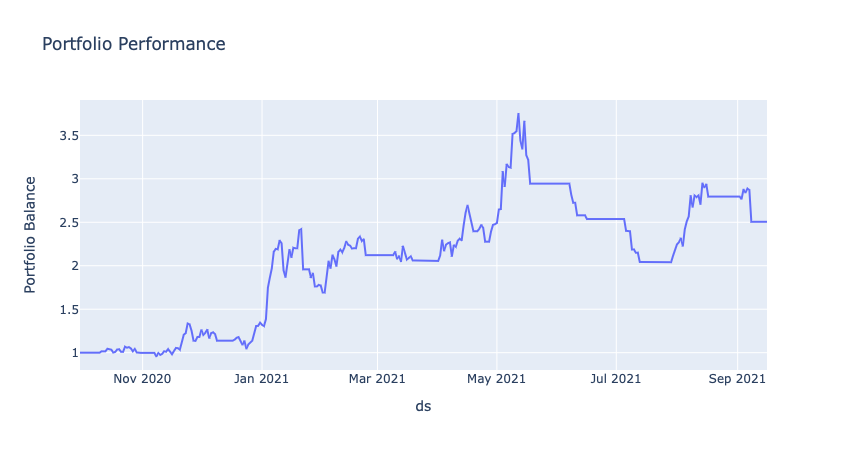

In [350]:
# Visualizing results
px.line(performance,
        x=performance.index,
        y=performance,
        title='Portfolio Performance',
        labels={"y": "Portfolio Balance"})